In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_rows = 8
% matplotlib inline

In [3]:
start = pd.to_datetime("01-01-1980")
end = pd.to_datetime("31-12-2016")
n = 250

In [4]:
events = [
    pd.to_datetime(x, unit="s")
    for x in np.random.uniform(start.timestamp(), end.timestamp(), n)
]
lengths = [pd.to_timedelta("{}h".format(abs(x))) for x in np.random.normal(6, 2, n)]
places = list(np.random.choice(["Amsterdam", "Birmingham"], n))
types = list(np.random.choice([1, 2, 3], n, p=[0.6, 0.3, 0.1]))

In [5]:
df = pd.DataFrame(
    {"time": events, "location": places, "severity": types},
    columns=["time", "location", "severity"],
).sort_values("time")
df = df.set_index("time")

This is a cute trick I discovered the other day for quickly computing the time since an event on regularly spaced time series data (like monthly reporting), without looping over the data. 

Say we have a list of workplace accidents at different factory locations for a company. We could have a dataframe that looks something like this:

In [6]:
df.head()

,location,severity
time,,
1980-01-07 23:37:50,Amsterdam,1
1980-01-31 16:51:04,Amsterdam,2
1980-07-05 05:20:49,Birmingham,1
1980-07-25 10:49:03,Amsterdam,1
1980-08-10 05:13:19,Amsterdam,1


Now, our company has decided they want to know how many months each location has gone without an accident, and they want this historically. Maybe they are going to use it as input for a machine learning model that makes monthly predictions, or they might just be curious. 

Our plan of attack is as follows:

1. One-hot encode the severity
2. Resample the data so that it is regularly spaced
3. For each severity, make a counter that increases per period, resetting whenever there was an accident during that period

Pandas makes step 1 very easy:

In [7]:
df_onehot = pd.get_dummies(df, columns=["severity"])
df_onehot.head()

,location,severity_1,severity_2,severity_3
time,,,,
1980-01-07 23:37:50,Amsterdam,1.0,0.0,0.0
1980-01-31 16:51:04,Amsterdam,0.0,1.0,0.0
1980-07-05 05:20:49,Birmingham,1.0,0.0,0.0
1980-07-25 10:49:03,Amsterdam,1.0,0.0,0.0
1980-08-10 05:13:19,Amsterdam,1.0,0.0,0.0


Next up, we resample. We want the data by location, so we will first group by location and then resample each group. Since we've one-hot encoded the data, the number of accidents in each period is just the sum of all the rows that fall into the period. Periods with no rows will be NaN, so we fill them with 0 since no accidents occurred in that period.

In [8]:
df_periodic = df_onehot.groupby("location").resample("1M").sum().fillna(0)
df_periodic

severity_1  severity_2  severity_3
location   time                                          
Amsterdam  1980-01-31         1.0         1.0         0.0
           1980-02-29         0.0         0.0         0.0
           1980-03-31         0.0         0.0         0.0
           1980-04-30         0.0         0.0         0.0
...                           ...         ...         ...
Birmingham 2016-09-30         0.0         0.0         0.0
           2016-10-31         0.0         0.0         0.0
           2016-11-30         0.0         0.0         0.0
           2016-12-31         0.0         1.0         0.0

[879 rows x 3 columns]

Finally, we want the counter that resets at each period where there was an accident. Let's first do it for one severity and location, and then we'll implement our work on the entire dataset. We'll choose Amsterdam and the lowest severity accidents. 

In [9]:
amsterdam_low = df_periodic.loc[("Amsterdam"), "severity_1"]
amsterdam_low

time
1980-01-31    1.0
1980-02-29    0.0
1980-03-31    0.0
1980-04-30    0.0
             ... 
2016-06-30    0.0
2016-07-31    0.0
2016-08-31    1.0
2016-09-30    1.0
Name: severity_1, dtype: float64

Okay, so we have a series with the number of accidents per month. 

Now here comes the trick. What we are going to do is set up two new series with the same index as the reports: one with a count that increases monotonically, and one that has the value of the count at every period where we want to reset. 

In [10]:
count = list(range(len(amsterdam_low)))
count = pd.Series(count, index=amsterdam_low.index)
count

time
1980-01-31      0
1980-02-29      1
1980-03-31      2
1980-04-30      3
             ... 
2016-06-30    437
2016-07-31    438
2016-08-31    439
2016-09-30    440
dtype: int64

In [11]:
resets = count.where(amsterdam_low > 0)
resets

time
1980-01-31      0.0
1980-02-29      NaN
1980-03-31      NaN
1980-04-30      NaN
              ...  
2016-06-30      NaN
2016-07-31      NaN
2016-08-31    439.0
2016-09-30    440.0
dtype: float64

Now we forward fill the values in `resets` using `.fillna(method='pad')`. That will give us a series of constant values, which step up by some amount at each index where there was an accident in `amsterdam_low`. This series will act as a baseline which we can subtract from `count`, so that at each accident the resulting series will reset to zero and then start counting up again. The first values before the first accident in the dataset will still be NaN, which is the desired behavious because we don't know what these values should be. 

In [12]:
resets = resets.fillna(method="pad")
resets

time
1980-01-31      0.0
1980-02-29      0.0
1980-03-31      0.0
1980-04-30      0.0
              ...  
2016-06-30    435.0
2016-07-31    435.0
2016-08-31    439.0
2016-09-30    440.0
dtype: float64

In [13]:
since_accident = count - resets
since_accident

time
1980-01-31    0.0
1980-02-29    1.0
1980-03-31    2.0
1980-04-30    3.0
             ... 
2016-06-30    2.0
2016-07-31    3.0
2016-08-31    0.0
2016-09-30    0.0
dtype: float64

Plotting the three series makes it clearer what exactly the trick was.

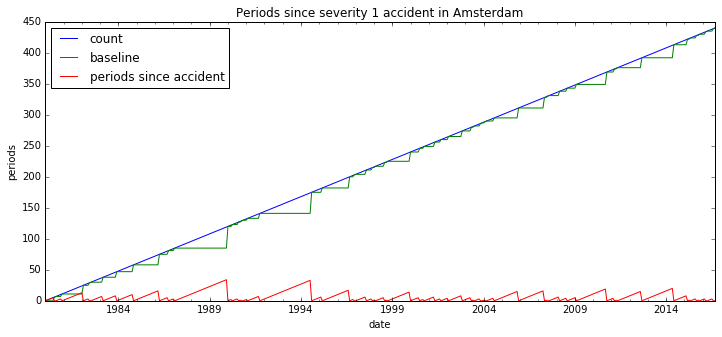

In [14]:
count.plot(figsize=(12, 5))
resets.plot()
since_accident.plot()
plt.legend(["count", "baseline", "periods since accident"], loc="best")
plt.ylabel("periods")
plt.xlabel("date")
plt.title("Periods since severity 1 accident in Amsterdam");

We've done it! What's nice about this trick is that we don't have to loop over all the accidents, so it scales well to larger data sets. To finish up, we do the same for all the accident types.

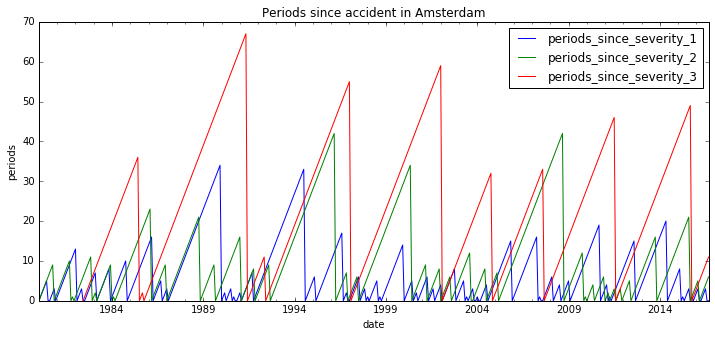

In [15]:
def periods_since_accident(group):
    g = group.copy()
    count = list(range(len(g)))
    count = pd.Series(count, index=group.index)

    for col in g.columns.tolist():
        resets = count.where(group[col] > 0).fillna(method="pad")
        g["periods_since_" + col] = count - resets

    return g


df_report = df_periodic.groupby(level=0).apply(periods_since_accident)

report_cols = [
    "periods_since_severity_1",
    "periods_since_severity_2",
    "periods_since_severity_3",
]
df_report.loc["Amsterdam"][report_cols].plot(figsize=(12, 5))
plt.title("Periods since accident in Amsterdam")
plt.xlabel("date")
plt.ylabel("periods");

We can even add one final column with the number of periods since any accident, just by taking the minimum of the other three columns.

In [16]:
df_report["periods_since_accident"] = df_report[report_cols].min(axis=1)
df_report[["periods_since_accident"]]

periods_since_accident
location   time                              
Amsterdam  1980-01-31                     0.0
           1980-02-29                     1.0
           1980-03-31                     2.0
           1980-04-30                     3.0
...                                       ...
Birmingham 2016-09-30                     3.0
           2016-10-31                     4.0
           2016-11-30                     5.0
           2016-12-31                     0.0

[879 rows x 1 columns]

Happy incident tracking!